In [226]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

In [227]:
spark = SparkSession.builder.appName("LinearRegressionExample").getOrCreate()

In [228]:
data = spark.read.csv('2022socio_economic_indonesia.csv',inferSchema =True, header=True)

In [229]:
data.printSchema()

root
 |-- province: string (nullable = true)
 |-- cities_reg: string (nullable = true)
 |-- poorpeople_percentage: double (nullable = true)
 |-- reg_gdp: double (nullable = true)
 |-- life_exp: double (nullable = true)
 |-- avg_schooltime: double (nullable = true)
 |-- exp_percap: integer (nullable = true)



In [230]:
data.show(5)

+--------+-------------+---------------------+-------+--------+--------------+----------+
|province|   cities_reg|poorpeople_percentage|reg_gdp|life_exp|avg_schooltime|exp_percap|
+--------+-------------+---------------------+-------+--------+--------------+----------+
|    Aceh|     Simeulue|                18.98|  2.275|   65.24|          9.48|      7148|
|    Aceh| Aceh Singkil|                20.36|  2.425|  67.355|          8.68|      8776|
|    Aceh| Aceh Selatan|                13.18|  5.531|   64.36|          8.88|      8180|
|    Aceh|Aceh Tenggara|                13.41|  5.063|  68.155|          9.67|      8030|
|    Aceh|   Aceh Timur|                14.45| 10.616|  68.705|          8.21|      8577|
+--------+-------------+---------------------+-------+--------+--------------+----------+
only showing top 5 rows



In [231]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns

for dirname, _, filenames in os.walk('2021socio_economic_indonesia'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [232]:
data = pd.read_csv("2022socio_economic_indonesia.csv")
data.head(10).style.background_gradient(cmap='inferno')

,province,cities_reg,poorpeople_percentage,reg_gdp,life_exp,avg_schooltime,exp_percap
0,Aceh,Simeulue,18.980000,2.275000,65.240000,9.480000,7148
1,Aceh,Aceh Singkil,20.360000,2.425000,67.355000,8.680000,8776
2,Aceh,Aceh Selatan,13.180000,5.531000,64.360000,8.880000,8180
3,Aceh,Aceh Tenggara,13.410000,5.063000,68.155000,9.670000,8030
4,Aceh,Aceh Timur,14.450000,10.616000,68.705000,8.210000,8577
5,Aceh,Aceh Tengah,15.260000,7.389000,68.790000,9.860000,10780
6,Aceh,Aceh Barat,18.810000,8.116000,67.945000,9.550000,9593
7,Aceh,Aceh Besar,14.050000,13.336000,69.745000,10.330000,9644
8,Aceh,Pidie,19.590000,10.760000,66.900000,9.000000,9860
9,Aceh,Bireuen,13.250000,13.090000,71.200000,9.290000,8867


In [233]:
"""
- Provinsi
- Kota/Kabupaten
- Persentase Penduduk Miskin
- PDRB (dalam miliar)
- Angka Harapan Hidup (AHH)
- Rata-rata Lama Sekolah
- Pengeluaran per Kapita

"""
columns_dt = pd.DataFrame({
    "Nama":data.columns
})
columns_dt.head(10)

,Nama
0,province
1,cities_reg
2,poorpeople_percentage
3,reg_gdp
4,life_exp
5,avg_schooltime
6,exp_percap


In [234]:
data.shape

(514, 7)

In [235]:
prov = pd.DataFrame({
    "Nama":data["province"].unique()
})

prov.head(-1)

,Nama
0,Aceh
1,Sumatera Utara
2,Sumatera Barat
3,Riau
4,Jambi
5,Sumatera Selatan
6,Bengkulu
7,Lampung
8,Kepulauan Bangka Belitung
9,Kepulauan Riau


In [236]:
dt_num_city = []
for i in prov["Nama"]:
    dt_num_city.append(data[data["province"] == i]["cities_reg"].nunique())

In [237]:
prov["Jml Kota"] = dt_num_city

In [238]:
prov.head(-1).style.background_gradient(cmap='inferno')

,Nama,Jml Kota
0,Aceh,23
1,Sumatera Utara,33
2,Sumatera Barat,19
3,Riau,12
4,Jambi,11
5,Sumatera Selatan,17
6,Bengkulu,10
7,Lampung,15
8,Kepulauan Bangka Belitung,7
9,Kepulauan Riau,7


In [239]:
poor = []
for i in data["province"].unique():
    poor.append(data[data["province"] == i]["poorpeople_percentage"].mean())
    
    
prov["Mean Poor"] = poor
prov.head(-1).style.background_gradient(cmap='inferno')

,Nama,Jml Kota,Mean Poor
0,Aceh,23,15.693913
1,Sumatera Utara,33,11.085455
2,Sumatera Barat,19,6.562632
3,Riau,12,8.342500
4,Jambi,11,7.977273
5,Sumatera Selatan,17,13.214118
6,Bengkulu,10,14.929000
7,Lampung,15,12.147333
8,Kepulauan Bangka Belitung,7,5.070000
9,Kepulauan Riau,7,7.694286


In [240]:
"""
provinsi dengan kemiskinan terendah
"""
prov[prov["Mean Poor"] == prov["Mean Poor"].min()].head()

,Nama,Jml Kota,Mean Poor
16,Bali,9,4.915556


In [241]:
"""
provinsi dengan kemiskinan tertinggi
"""
prov[prov["Mean Poor"] == prov["Mean Poor"].max()].head()

,Nama,Jml Kota,Mean Poor
33,Papua,29,28.37931


In [242]:
gdp = []
for i in data["province"].unique():
    gdp.append(data[data["province"] == i]["reg_gdp"].mean())
    
    
prov["Mean GDP"] = gdp
prov.head(-1).style.background_gradient(cmap='inferno')

,Nama,Jml Kota,Mean Poor,Mean GDP
0,Aceh,23,15.693913,7.241043
1,Sumatera Utara,33,11.085455,24.910121
2,Sumatera Barat,19,6.562632,12.730474
3,Riau,12,8.342500,61.057083
4,Jambi,11,7.977273,18.886182
5,Sumatera Selatan,17,13.214118,27.210353
6,Bengkulu,10,14.929000,7.338900
7,Lampung,15,12.147333,23.978533
8,Kepulauan Bangka Belitung,7,5.070000,10.805429
9,Kepulauan Riau,7,7.694286,36.033714


In [243]:
"""
provinsi dengan GDP terendah
"""
prov[prov["Mean GDP"] == prov["Mean GDP"].min()].head()

,Nama,Jml Kota,Mean Poor,Mean GDP
31,Maluku Utara,10,8.029,4.2564


In [244]:
"""
provinsi dengan GDP tertinggi
"""
prov[prov["Mean GDP"] == prov["Mean GDP"].max()].head()

,Nama,Jml Kota,Mean Poor,Mean GDP
10,DKI Jakarta,6,6.565,465.185667


In [245]:
life = []
for i in data["province"].unique():
    life.append(data[data["province"] == i]["life_exp"].mean())
    
    
prov["Mean Life (Tahun)"] = life

In [246]:
# prov.drop(["Mean Life"],axis=1, inplace=True)
prov.head(-1).style.background_gradient(cmap='inferno')

,Nama,Jml Kota,Mean Poor,Mean GDP,Mean Life (Tahun)
0,Aceh,23,15.693913,7.241043,68.256739
1,Sumatera Utara,33,11.085455,24.910121,69.102121
2,Sumatera Barat,19,6.562632,12.730474,70.284474
3,Riau,12,8.342500,61.057083,70.200833
4,Jambi,11,7.977273,18.886182,69.970909
5,Sumatera Selatan,17,13.214118,27.210353,67.998235
6,Bengkulu,10,14.929000,7.338900,67.604500
7,Lampung,15,12.147333,23.978533,69.250333
8,Kepulauan Bangka Belitung,7,5.070000,10.805429,71.054286
9,Kepulauan Riau,7,7.694286,36.033714,68.831429


In [247]:
"""
provinsi dengan GDP terendah
"""
prov[prov["Mean Life (Tahun)"] == prov["Mean Life (Tahun)"].min()].head()

,Nama,Jml Kota,Mean Poor,Mean GDP,Mean Life (Tahun)
30,Maluku,11,21.444545,4.260091,64.590455


In [248]:
"""
provinsi dengan GDP tertinggi
"""
prov[prov["Mean Life (Tahun)"] == prov["Mean Life (Tahun)"].max()].head()

,Nama,Jml Kota,Mean Poor,Mean GDP,Mean Life (Tahun)
12,Jawa Tengah,35,11.392571,38.493371,75.030571


In [249]:
sch = []
for i in data["province"].unique():
    sch.append(data[data["province"] == i]["avg_schooltime"].mean())
    
    
prov["Mean School"] = sch

prov.head(-1).style.background_gradient(cmap='inferno')

,Nama,Jml Kota,Mean Poor,Mean GDP,Mean Life (Tahun),Mean School
0,Aceh,23,15.693913,7.241043,68.256739,9.503478
1,Sumatera Utara,33,11.085455,24.910121,69.102121,9.180909
2,Sumatera Barat,19,6.562632,12.730474,70.284474,9.244211
3,Riau,12,8.342500,61.057083,70.200833,9.050833
4,Jambi,11,7.977273,18.886182,69.970909,8.501818
5,Sumatera Selatan,17,13.214118,27.210353,67.998235,8.221176
6,Bengkulu,10,14.929000,7.338900,67.604500,8.612000
7,Lampung,15,12.147333,23.978533,69.250333,8.183333
8,Kepulauan Bangka Belitung,7,5.070000,10.805429,71.054286,8.095714
9,Kepulauan Riau,7,7.694286,36.033714,68.831429,8.771429


In [250]:
exp = []
for i in data["province"].unique():
    exp.append(data[data["province"] == i]["exp_percap"].mean())
    
    
prov["Mean Expenses"] = exp

prov.head(-1).style.background_gradient(cmap='inferno')

,Nama,Jml Kota,Mean Poor,Mean GDP,Mean Life (Tahun),Mean School,Mean Expenses
0,Aceh,23,15.693913,7.241043,68.256739,9.503478,9642.782609
1,Sumatera Utara,33,11.085455,24.910121,69.102121,9.180909,10401.151515
2,Sumatera Barat,19,6.562632,12.730474,70.284474,9.244211,10712.315789
3,Riau,12,8.342500,61.057083,70.200833,9.050833,10753.916667
4,Jambi,11,7.977273,18.886182,69.970909,8.501818,10453.181818
5,Sumatera Selatan,17,13.214118,27.210353,67.998235,8.221176,10512.352941
6,Bengkulu,10,14.929000,7.338900,67.604500,8.612000,10222.100000
7,Lampung,15,12.147333,23.978533,69.250333,8.183333,9762.000000
8,Kepulauan Bangka Belitung,7,5.070000,10.805429,71.054286,8.095714,12920.714286
9,Kepulauan Riau,7,7.694286,36.033714,68.831429,8.771429,14049.142857


Text(0.5, 1.0, 'Lama Sekolah vs GDP')

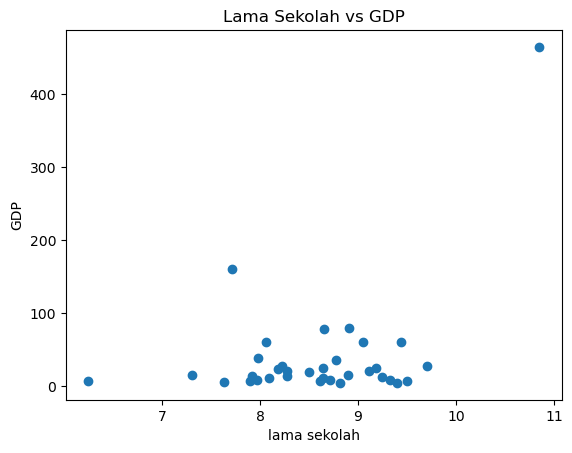

In [251]:
plt.scatter(data=prov, x='Mean School', y='Mean GDP')
plt.xlabel("lama sekolah")
plt.ylabel("GDP")
plt.title("Lama Sekolah vs GDP")

Text(0.5, 1.0, 'Lama Sekolah vs Kemiskinan')

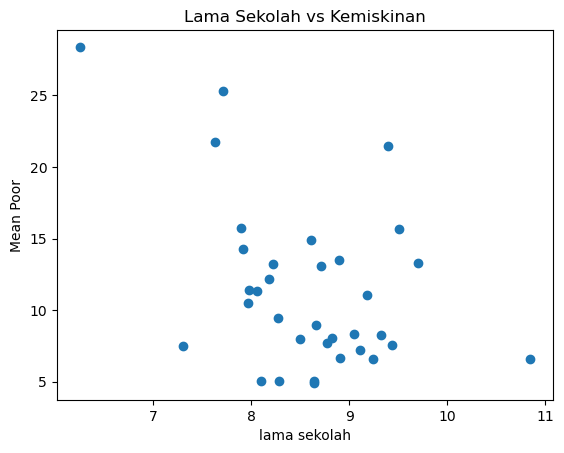

In [252]:
plt.scatter(data=prov, x='Mean School', y='Mean Poor')
plt.xlabel("lama sekolah")
plt.ylabel("Mean Poor")
plt.title("Lama Sekolah vs Kemiskinan")

Text(0.5, 1.0, 'GDP vs Pengeluaran per kapita')

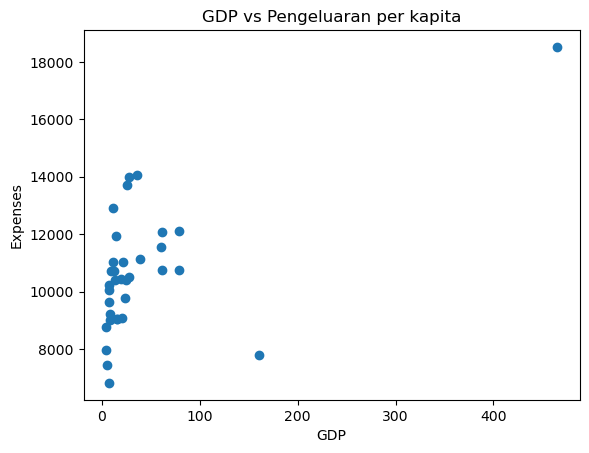

In [253]:
plt.scatter(data=prov, x='Mean GDP', y='Mean Expenses')
plt.xlabel("GDP")
plt.ylabel("Expenses")
plt.title("GDP vs Pengeluaran per kapita")

,Nama,Jml Kota,Mean Poor,Mean GDP,Mean Life (Tahun),Mean School,Mean Expenses
31,Maluku Utara,10,8.029,4.2564,66.8135,8.82,7955.8


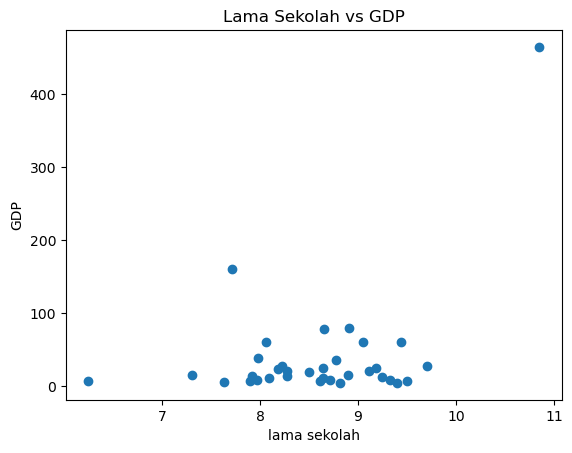

In [254]:
plt.scatter(data=prov, x='Mean School', y='Mean GDP')
plt.xlabel("lama sekolah")
plt.ylabel("GDP")
plt.title("Lama Sekolah vs GDP")
prov[prov["Mean GDP"] == prov["Mean GDP"].min()].head()

In [255]:
data.isnull().sum()

province                 0
cities_reg               0
poorpeople_percentage    0
reg_gdp                  0
life_exp                 0
avg_schooltime           0
exp_percap               0
dtype: int64

In [256]:
data.describe()

,poorpeople_percentage,reg_gdp,life_exp,avg_schooltime,exp_percap
count,514.000000,514.000000,514.000000,514.000000,514.000000
mean,12.273152,34.798333,69.619076,8.436615,10324.787938
std,7.458703,84.155498,3.455911,1.630842,2717.144186
min,2.380000,1.042000,55.370000,1.420000,3976.000000
25%,7.150000,5.587500,67.336250,7.510000,8574.000000
50%,10.455000,13.068500,69.922500,8.305000,10196.500000
75%,14.887500,28.849500,72.018750,9.337500,11719.000000
max,41.660000,819.000000,77.855000,12.830000,23888.000000


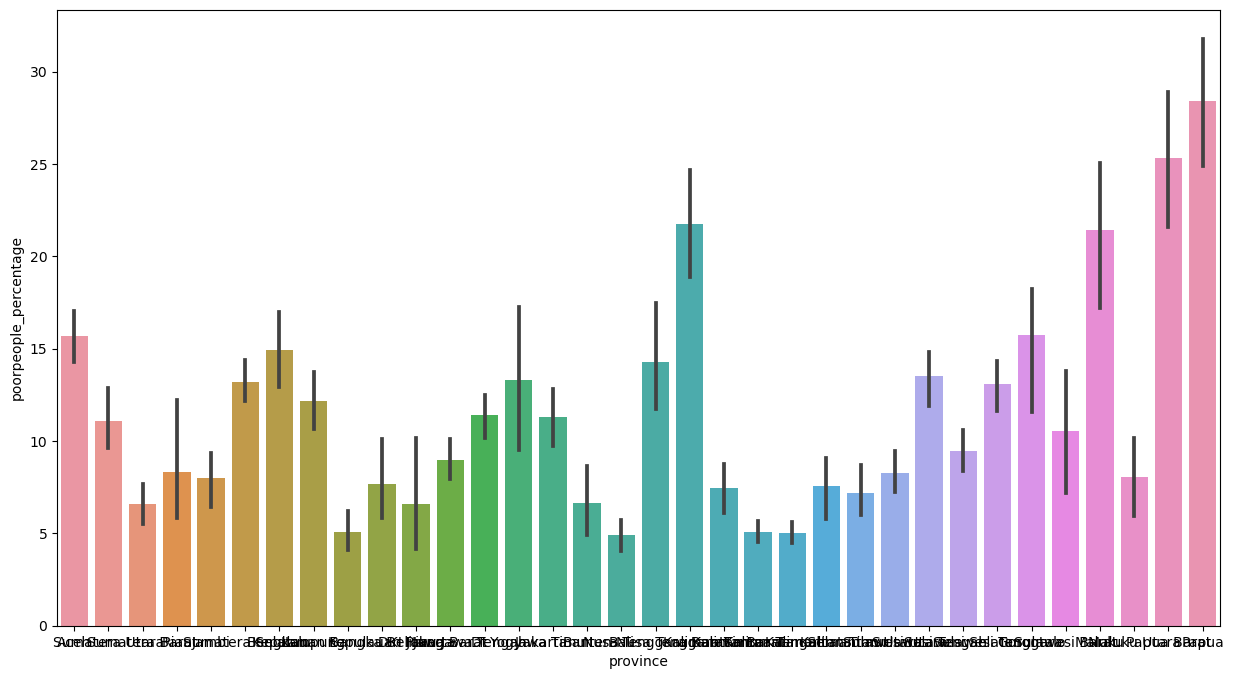

In [257]:
plt.figure(figsize=(15, 8))
sns.barplot(x='province', y='poorpeople_percentage', data=data)
plt.show()

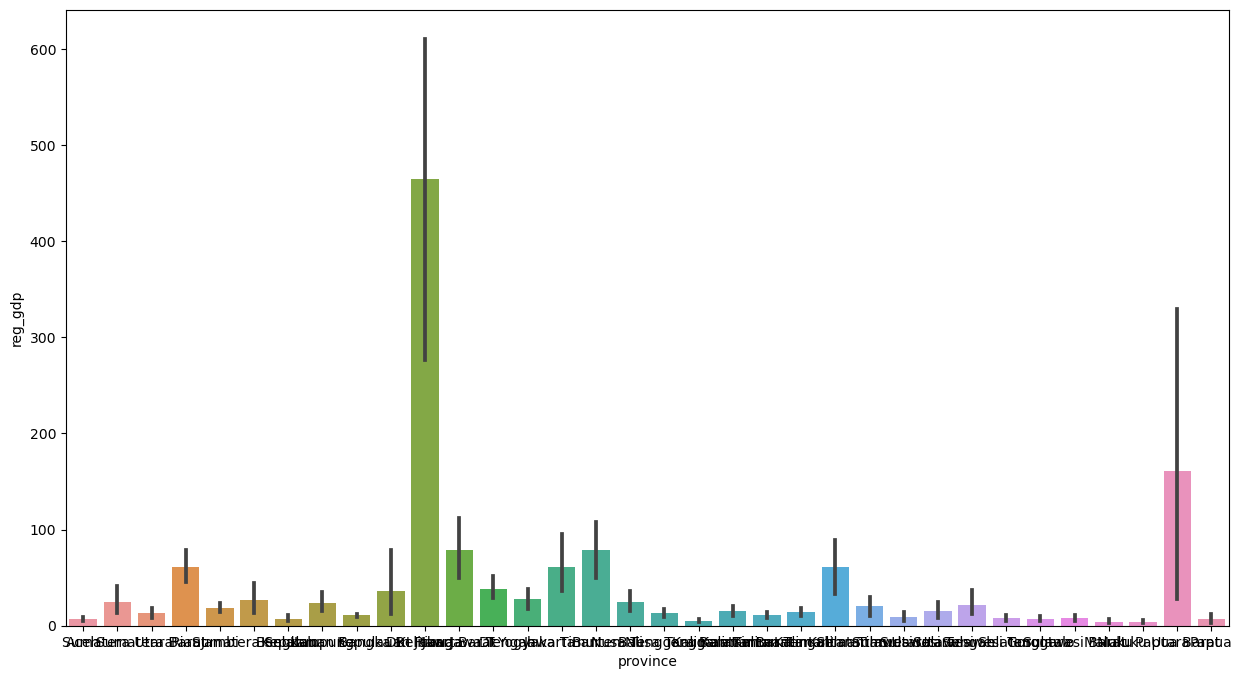

In [258]:
plt.figure(figsize=(15, 8))
sns.barplot(x='province', y='reg_gdp', data=data)
plt.show()

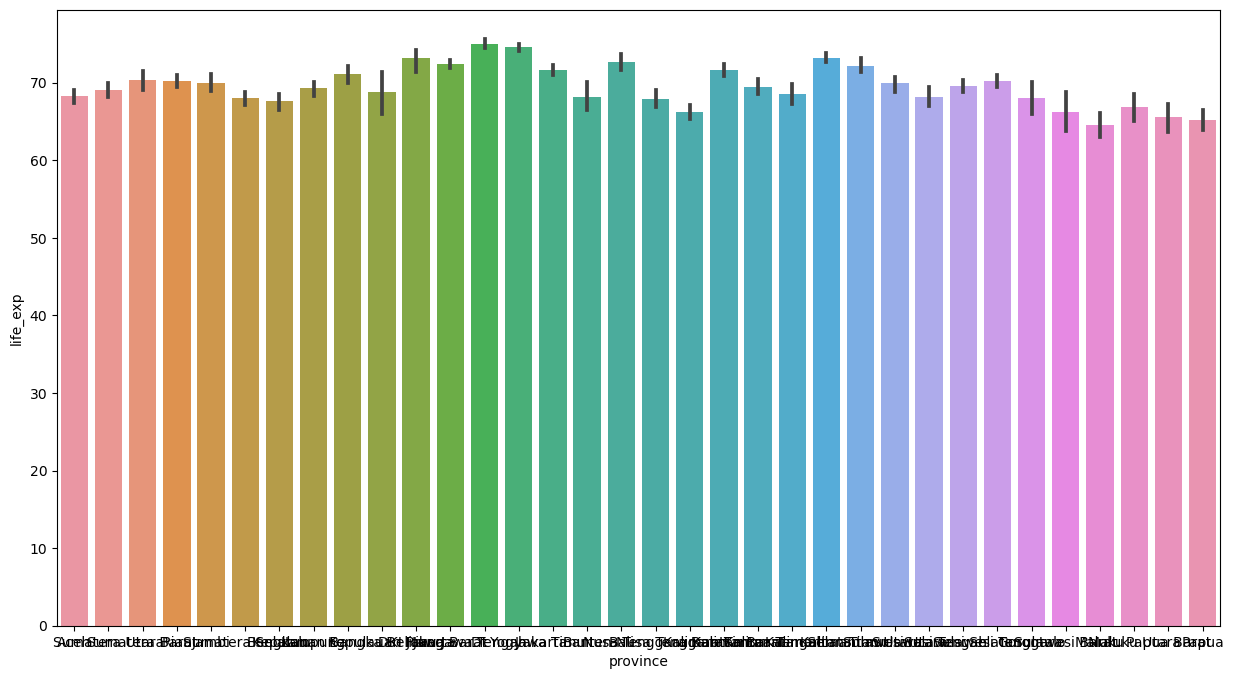

In [259]:
plt.figure(figsize=(15, 8))
sns.barplot(x='province', y='life_exp', data=data)
plt.show()

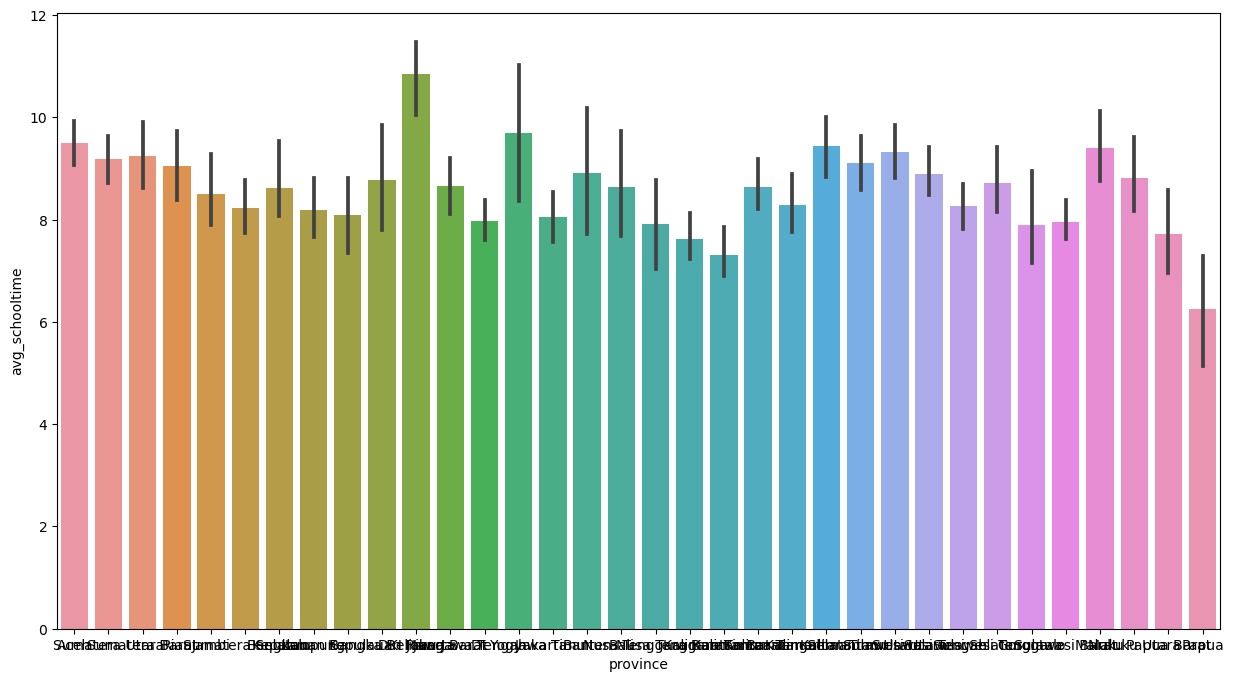

In [260]:
plt.figure(figsize=(15, 8))
sns.barplot(x='province', y='avg_schooltime', data=data)
plt.show()

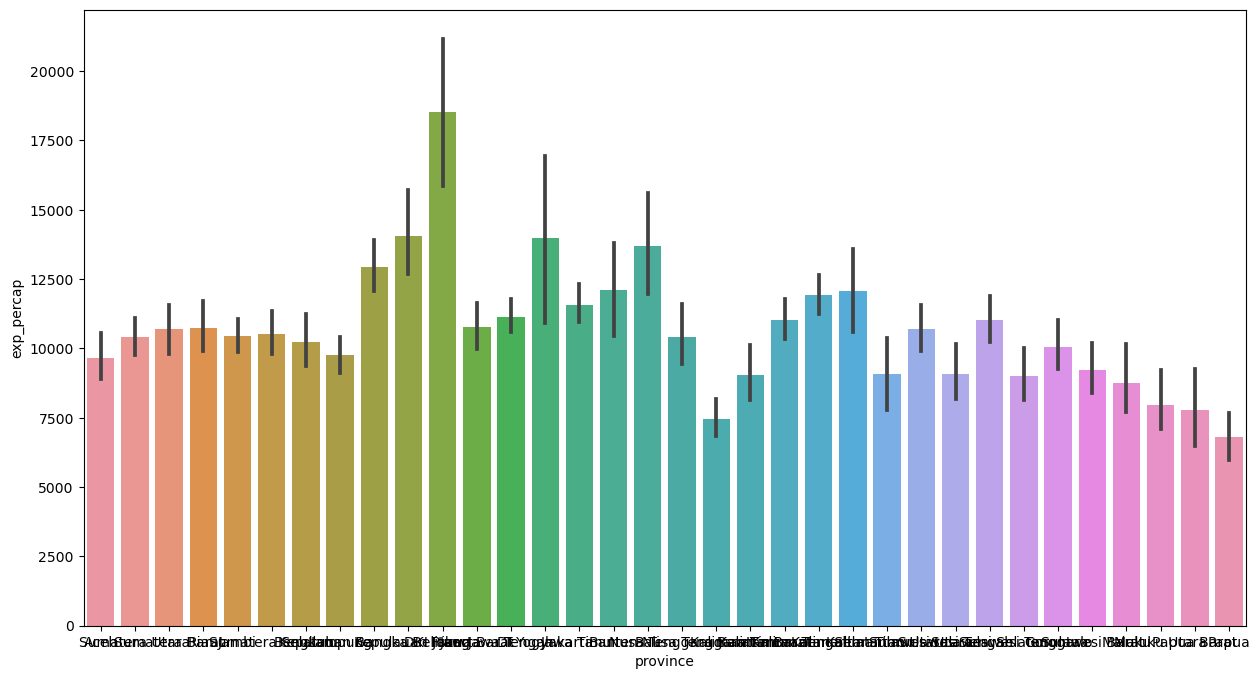

In [261]:
plt.figure(figsize=(15, 8))
sns.barplot(x='province', y='exp_percap', data=data)
plt.show()

In [262]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [263]:
spark = SparkSession.builder.appName("LinearRegressionExample").getOrCreate()
data = spark.read.csv('2022socio_economic_indonesia.csv', inferSchema=True, header=True)

In [264]:
# Assuming 'province' is a string column in your DataFrame
indexer = StringIndexer(inputCol="province", outputCol="province_index")
assembler = VectorAssembler(inputCols=["province_index", "reg_gdp", "life_exp", "avg_schooltime", "exp_percap"],
                            outputCol="features")
lr = LinearRegression(labelCol="poorpeople_percentage", featuresCol="features")

pipeline = Pipeline(stages=[indexer, assembler, lr])

(training_data, test_data) = data.randomSplit([0.8, 0.2], seed=123)

In [265]:
# Set up the parameter grid for tuning
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.1, 0.2]).build()

# Set up cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="poorpeople_percentage", metricName="rmse"),
                          numFolds=3)

In [266]:
# Fit the model
cv_model = crossval.fit(training_data)

# Make predictions on the test set
predictions = cv_model.transform(test_data)

# Visualize predicted vs actual values
predictions.select("poorpeople_percentage", "prediction").show()

# Convert predictions DataFrame to Pandas for visualization
predictions_pd = predictions.select("poorpeople_percentage", "prediction").toPandas()

+---------------------+-------------------+
|poorpeople_percentage|         prediction|
+---------------------+-------------------+
|                14.05| 11.552652351485605|
|                13.34| 14.052016275533234|
|                13.25| 12.135287921203371|
|                19.64| 17.023101338412218|
|                17.65| 19.720354757105994|
|                 2.62|-1.7236097299772979|
|                 5.64|  8.079666171519548|
|                 2.96|  -4.39636276122657|
|                 6.79| 7.5240459419616315|
|                 5.93| 3.5207303289146523|
|                 2.57|0.06646465349012942|
|                 5.49| 14.100157971400776|
|                18.16| 11.454346719386734|
|                11.93| 12.803216738898499|
|                15.06|  7.461846819420117|
|                 19.0| 11.963304015846788|
|                 6.68| 11.674795986957562|
|                 5.21| 12.538744483929435|
|                10.65| 15.186750077699827|
|                 8.25|   9.0768

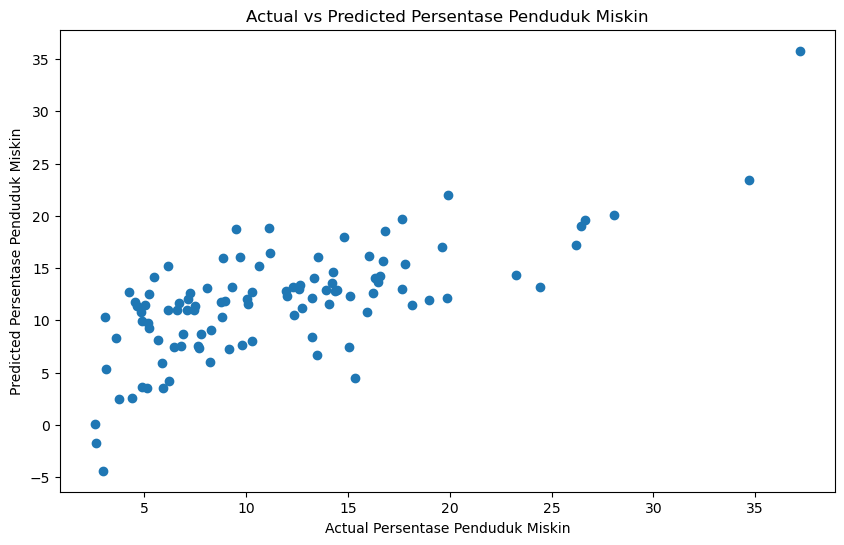

In [267]:
# Scatter plot for predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["poorpeople_percentage"], predictions_pd["prediction"])
plt.xlabel("Actual Persentase Penduduk Miskin")
plt.ylabel("Predicted Persentase Penduduk Miskin")
plt.title("Actual vs Predicted Persentase Penduduk Miskin")
plt.show()

In [268]:
# Set up the parameter grid for tuning
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.1, 0.2]).build()

# Set up cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="reg_gdp", metricName="rmse"),
                          numFolds=3)

In [269]:
# Fit the model
cv_model = crossval.fit(training_data)

# Make predictions on the test set
predictions = cv_model.transform(test_data)

# Visualize predicted vs actual values
predictions.select("reg_gdp", "prediction").show()

# Convert predictions DataFrame to Pandas for visualization
predictions_pd = predictions.select("reg_gdp", "prediction").toPandas()

+-------+-------------------+
|reg_gdp|         prediction|
+-------+-------------------+
| 13.336| 11.592435394185813|
|  7.513|  14.10056331134109|
|  13.09| 12.152731222851386|
|  2.695|  17.12668101790935|
|  1.804| 19.874548431342383|
| 49.215| -1.998574331339583|
|  8.468|  7.933576955479339|
| 49.583| -4.703427519206244|
|  31.58|   7.39427982107226|
| 143.84| 3.4065580274525473|
| 82.551|-0.1223312329879036|
| 76.601| 14.099238786177523|
|  5.824| 11.432884275695002|
|  5.265| 12.783101721949492|
|  6.347|   7.31898273126906|
|  5.491| 11.861127342928256|
| 14.759| 11.613078447403936|
|317.943| 12.700103464786181|
| 58.043| 15.239742434358476|
| 12.402|   9.04334866844566|
+-------+-------------------+
only showing top 20 rows



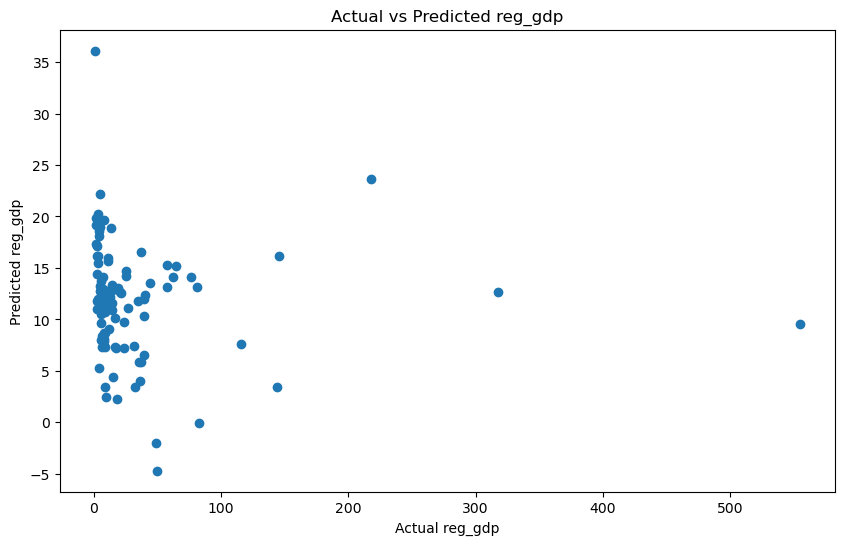

In [270]:
# Scatter plot for predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["reg_gdp"], predictions_pd["prediction"])
plt.xlabel("Actual reg_gdp")
plt.ylabel("Predicted reg_gdp")
plt.title("Actual vs Predicted reg_gdp")
plt.show()

In [271]:
# Set up the parameter grid for tuning
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.1, 0.2]).build()

# Set up cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="life_exp", metricName="rmse"),
                          numFolds=3)

In [272]:
# Fit the model
cv_model = crossval.fit(training_data)

# Make predictions on the test set
predictions = cv_model.transform(test_data)

# Visualize predicted vs actual values
predictions.select("life_exp", "prediction").show()

# Convert predictions DataFrame to Pandas for visualization
predictions_pd = predictions.select("life_exp", "prediction").toPandas()

+--------+-------------------+
|life_exp|         prediction|
+--------+-------------------+
|  69.745| 11.552652351485605|
|  69.565| 14.052016275533234|
|    71.2| 12.135287921203371|
|  65.475| 17.023101338412218|
|  64.025| 19.720354757105994|
|   75.06|-1.7236097299772979|
|  71.355|  8.079666171519548|
|   74.88|  -4.39636276122657|
|  67.985| 7.5240459419616315|
|   71.55| 3.5207303289146523|
|   72.43|0.06646465349012942|
|  64.715| 14.100157971400776|
|  67.935| 11.454346719386734|
|   66.72| 12.803216738898499|
|  68.935|  7.461846819420117|
|  69.275| 11.963304015846788|
|   69.97| 11.674795986957562|
|   73.81| 12.538744483929435|
|   71.61| 15.186750077699827|
|  72.595|   9.07684078908666|
+--------+-------------------+
only showing top 20 rows



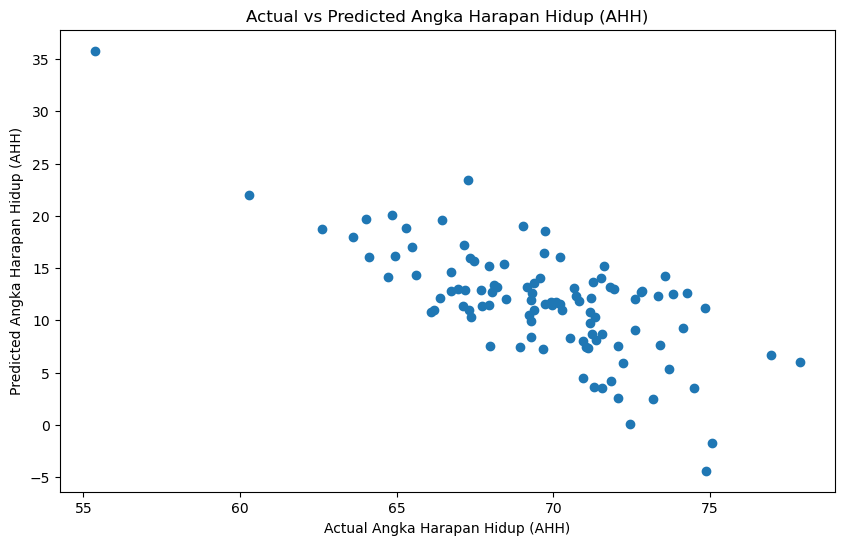

In [273]:
# Scatter plot for predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["life_exp"], predictions_pd["prediction"])
plt.xlabel("Actual Angka Harapan Hidup (AHH)")
plt.ylabel("Predicted Angka Harapan Hidup (AHH)")
plt.title("Actual vs Predicted Angka Harapan Hidup (AHH)")
plt.show()

In [274]:
# Set up the parameter grid for tuning
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.1, 0.2]).build()

# Set up cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="avg_schooltime", metricName="rmse"),
                          numFolds=3)

In [275]:
# Fit the model
cv_model = crossval.fit(training_data)

# Make predictions on the test set
predictions = cv_model.transform(test_data)

# Visualize predicted vs actual values
predictions.select("avg_schooltime", "prediction").show()

# Convert predictions DataFrame to Pandas for visualization
predictions_pd = predictions.select("avg_schooltime", "prediction").toPandas()

+--------------+-------------------+
|avg_schooltime|         prediction|
+--------------+-------------------+
|         10.33| 11.552652351485605|
|          8.91| 14.052016275533234|
|          9.29| 12.135287921203371|
|           8.4| 17.023101338412218|
|          8.03| 19.720354757105994|
|         10.62|-1.7236097299772979|
|          8.14|  8.079666171519548|
|         11.48|  -4.39636276122657|
|          8.89| 7.5240459419616315|
|         10.83| 3.5207303289146523|
|         11.82|0.06646465349012942|
|          7.51| 14.100157971400776|
|          9.27| 11.454346719386734|
|           8.3| 12.803216738898499|
|          8.81|  7.461846819420117|
|           7.0| 11.963304015846788|
|          7.59| 11.674795986957562|
|           9.3| 12.538744483929435|
|          7.53| 15.186750077699827|
|          9.81|   9.07684078908666|
+--------------+-------------------+
only showing top 20 rows



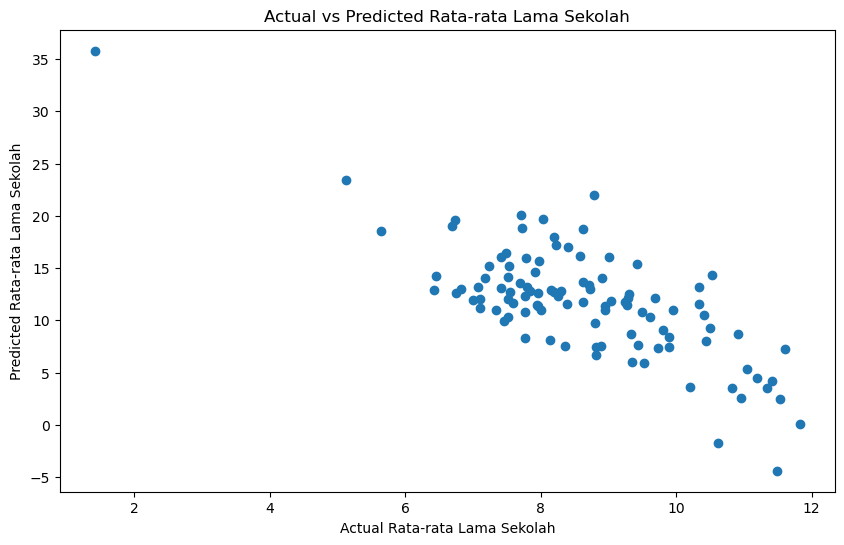

In [276]:
# Scatter plot for predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["avg_schooltime"], predictions_pd["prediction"])
plt.xlabel("Actual Rata-rata Lama Sekolah")
plt.ylabel("Predicted Rata-rata Lama Sekolah")
plt.title("Actual vs Predicted Rata-rata Lama Sekolah")
plt.show()

In [277]:
# Set up the parameter grid for tuning
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.1, 0.2]).build()

# Set up cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="exp_percap", metricName="rmse"),
                          numFolds=3)

In [278]:
# Fit the model
cv_model = crossval.fit(training_data)

# Make predictions on the test set
predictions = cv_model.transform(test_data)

# Visualize predicted vs actual values
predictions.select("exp_percap", "prediction").show()

# Convert predictions DataFrame to Pandas for visualization
predictions_pd = predictions.select("exp_percap", "prediction").toPandas()

+----------+-------------------+
|exp_percap|         prediction|
+----------+-------------------+
|      9644| 11.552652351485605|
|      8367| 14.052016275533234|
|      8867| 12.135287921203371|
|      8856| 17.023101338412218|
|      7385| 19.720354757105994|
|     17327|-1.7236097299772979|
|     11287|  8.079666171519548|
|     19598|  -4.39636276122657|
|     13281| 7.5240459419616315|
|     14575| 3.5207303289146523|
|     15751|0.06646465349012942|
|     10713| 14.100157971400776|
|      9916| 11.454346719386734|
|     10405| 12.803216738898499|
|     12587|  7.461846819420117|
|      8940| 11.963304015846788|
|     10546| 11.674795986957562|
|     11341| 12.538744483929435|
|      7961| 15.186750077699827|
|     10942|   9.07684078908666|
+----------+-------------------+
only showing top 20 rows



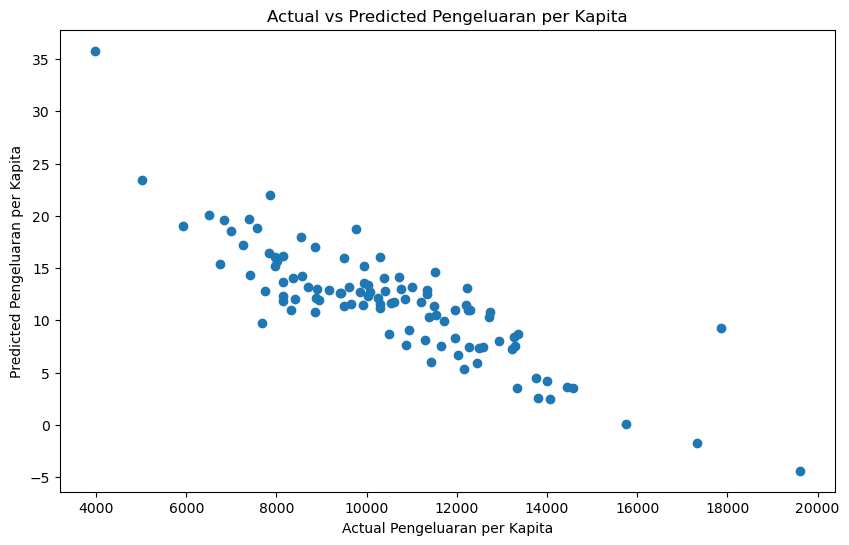

In [279]:
# Scatter plot for predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["exp_percap"], predictions_pd["prediction"])
plt.xlabel("Actual Pengeluaran per Kapita")
plt.ylabel("Predicted Pengeluaran per Kapita")
plt.title("Actual vs Predicted Pengeluaran per Kapita")
plt.show()

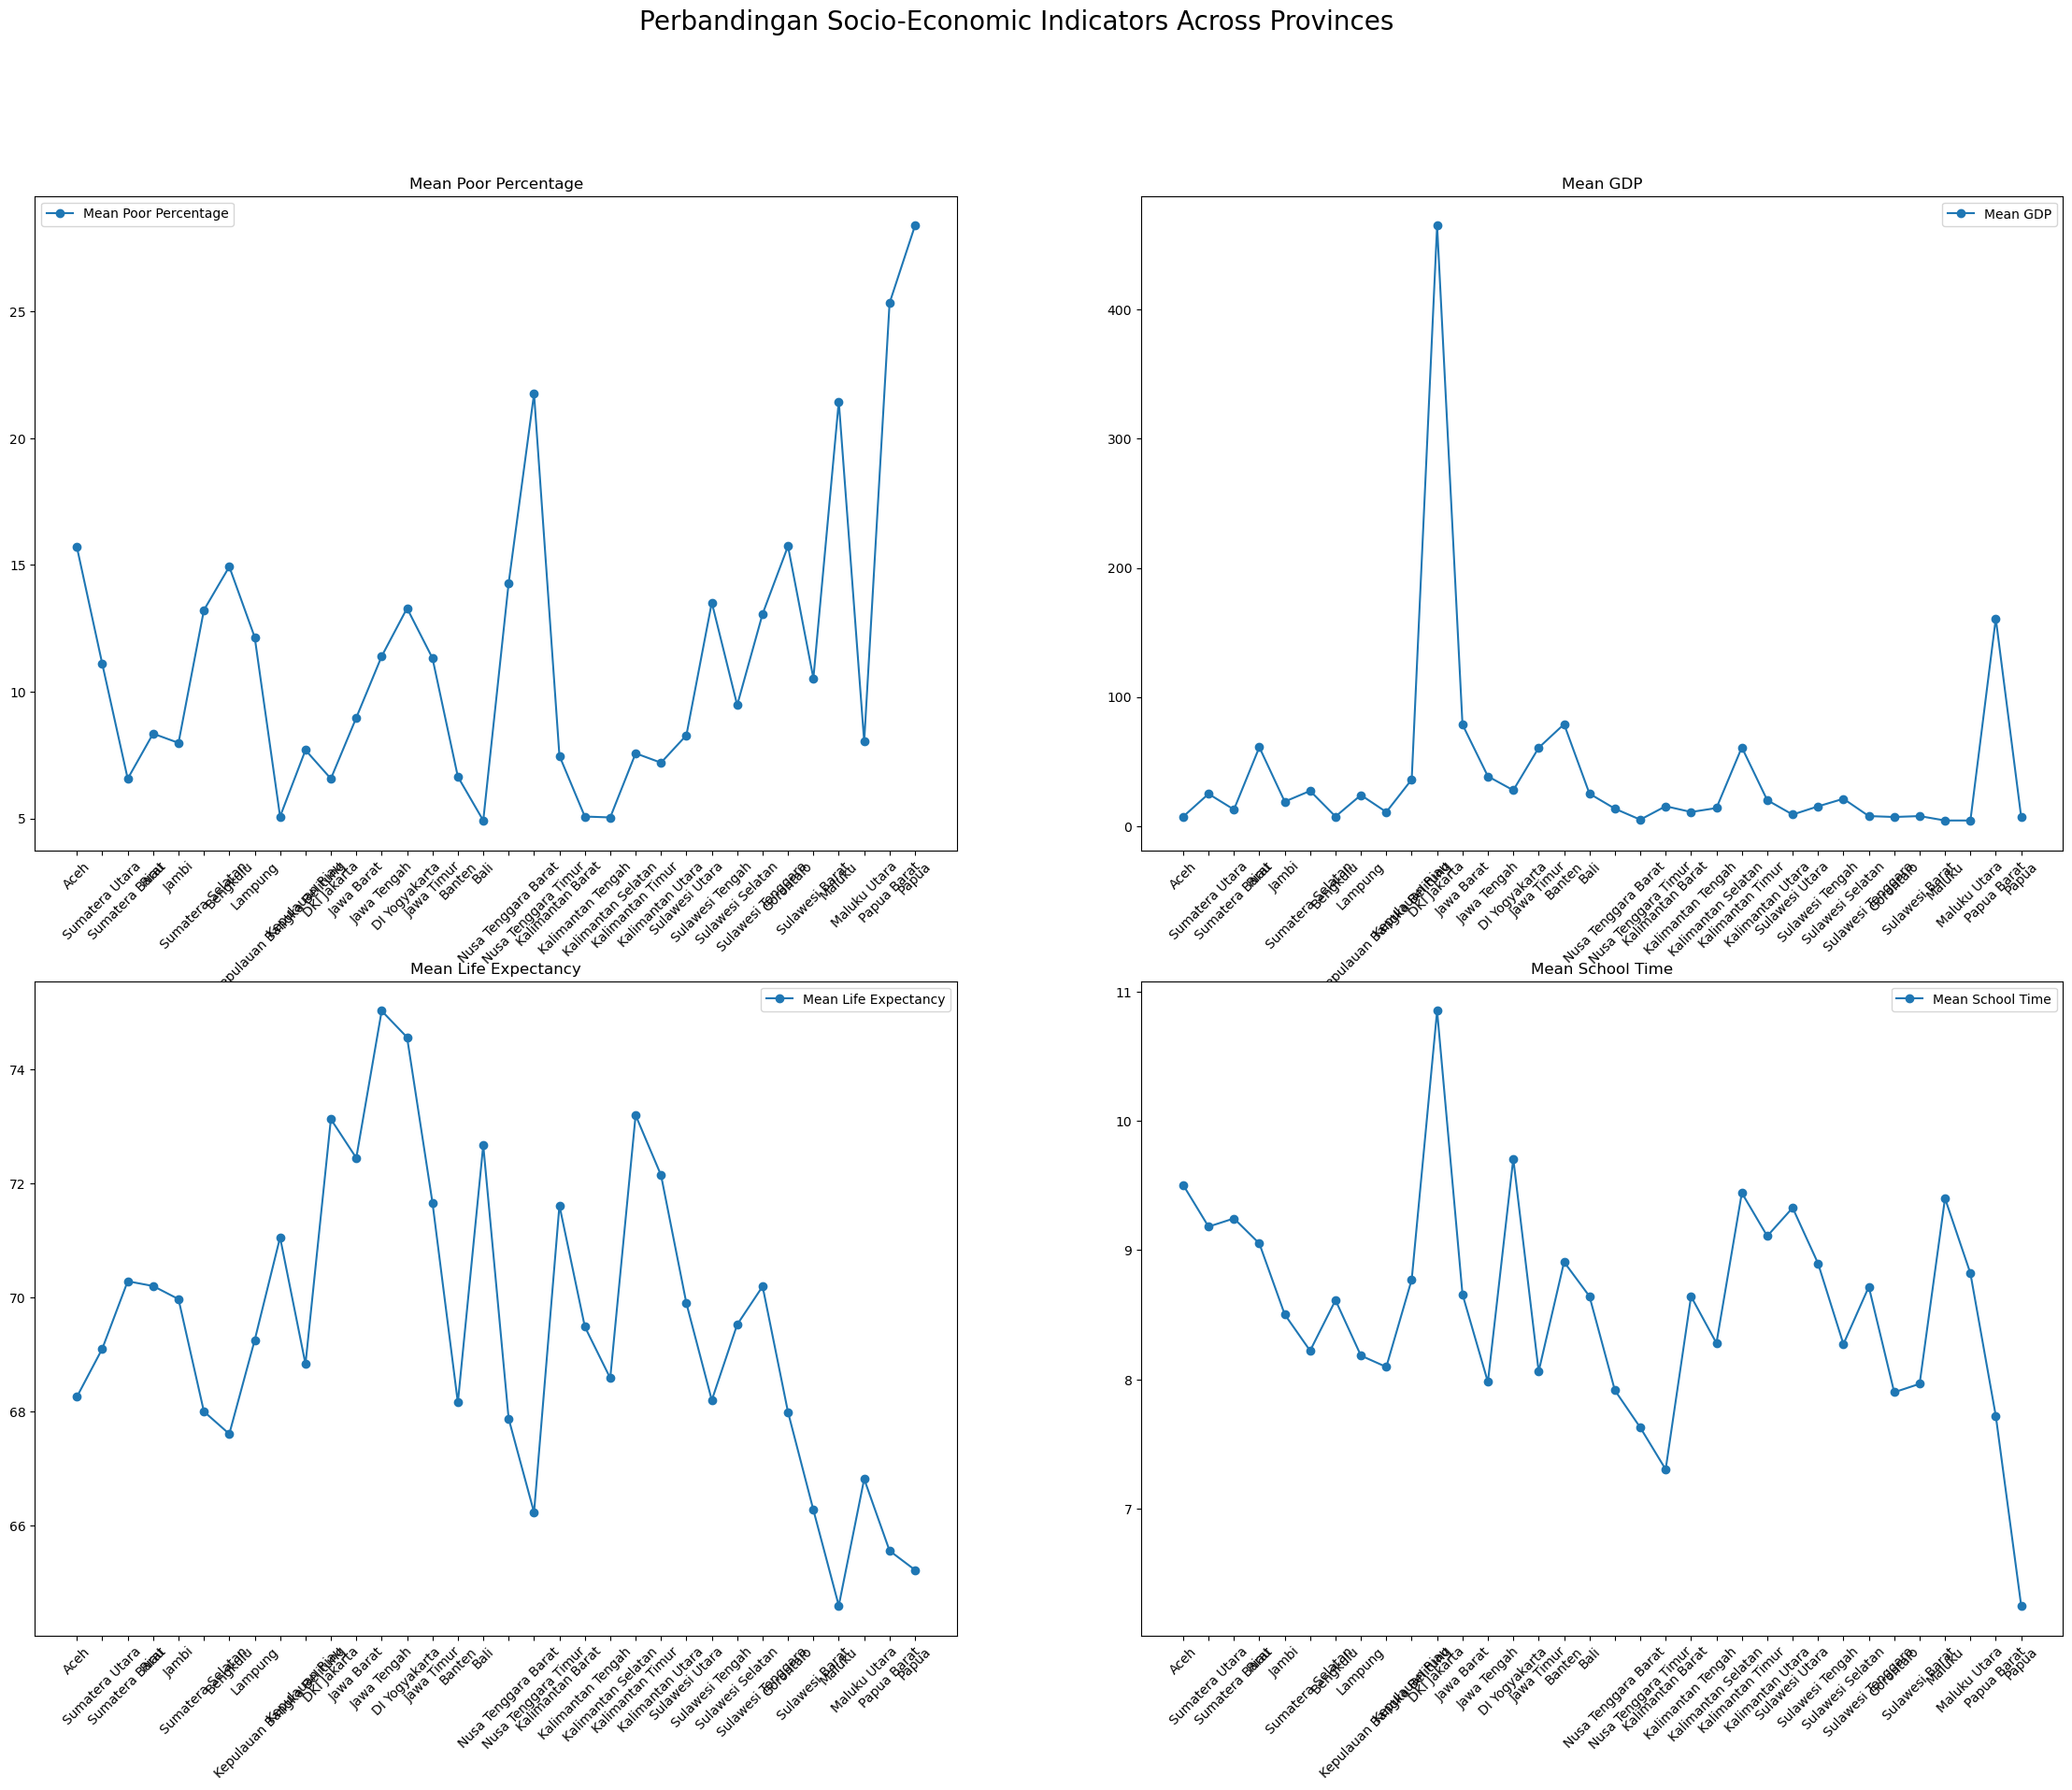

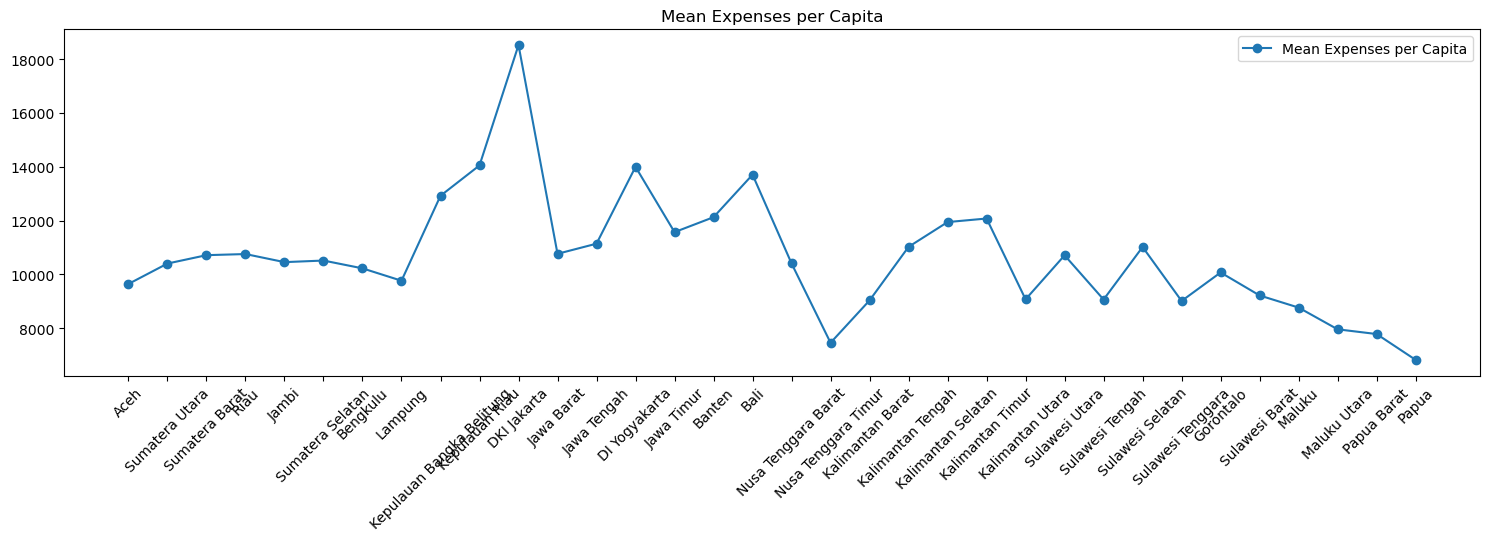

In [280]:
fig, axs = plt.subplots(2, 2, figsize=(28, 20))
fig.suptitle('Perbandingan Socio-Economic Indicators Across Provinces', fontsize=20)

# Line chart for Mean Poor Percentage
axs[0, 0].plot(provinces, poor_percentage, label='Mean Poor Percentage', marker='o')
axs[0, 0].set_title('Mean Poor Percentage')
axs[0, 0].legend()
axs[0, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Line chart for Mean GDP
axs[0, 1].plot(provinces, gdp, label='Mean GDP', marker='o')
axs[0, 1].set_title('Mean GDP')
axs[0, 1].legend()
axs[0, 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Line chart for Mean Life Expectancy
axs[1, 0].plot(provinces, life_expectancy, label='Mean Life Expectancy', marker='o')
axs[1, 0].set_title('Mean Life Expectancy')
axs[1, 0].legend()
axs[1, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Line chart for Mean School Time
axs[1, 1].plot(provinces, avg_schooltime, label='Mean School Time', marker='o')
axs[1, 1].set_title('Mean School Time')
axs[1, 1].legend()
axs[1, 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Line chart for Mean Expenses per Capita (alone in the fifth subplot)
fig, ax_expenses = plt.subplots(figsize=(15, 6))
ax_expenses.plot(provinces, expenses_percapita, label='Mean Expenses per Capita', marker='o')
ax_expenses.set_title('Mean Expenses per Capita')
ax_expenses.legend()
ax_expenses.tick_params(axis='x', rotation=45)  # Rotate x-axis labels

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
